# Dog-Friendly Neighbourhoods of Stockholm

<img src="https://miro.medium.com/max/1800/1*Ajbb76yGEqKPRdbp-rrn4g.jpeg" alt="dogswelcome" align="left" width=600>

# Step 1. Downloading the libraries that will be required

In [1]:
import pandas as pd # library for data analsysis
import numpy as np  # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Step 2. Processing the data

After a bit of search for map data about the districts of Stockholm, I ended up manually scrapping the Wikipedia page https://en.wikipedia.org/wiki/Districts_of_Sweden for information about the districts. I have created the file called stockholm_districts.csv containing the Boroughs and Districts of Stockholm.

In [8]:
data = pd.read_csv("/Users/liuba/Desktop/GitHub/Coursera_Capstone/stockholm_districts.csv")

Next I added the columns for lattitude and longitude of each district and I retrieved this information using Nominatim that we learned about during the labs.

In [9]:
for i in range(115):
    address = data.iloc[i,2] + ", "+ data.iloc[i,1] + ", "+ data.iloc[i,0]
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address)
    if location is not None:
        data.at[i,'Lat'] = float(location.latitude)
        data.at[i,'Long'] = float(location.longitude)
        #print(i,float(location.latitude)," ",float(location.longitude))
    else:
        address = data.iloc[i,2] + ", "+ data.iloc[i,0]
        geolocator = Nominatim(user_agent="explorer")
        location = geolocator.geocode(address)
        if location is not None:
            data.at[i,'Lat'] = float(location.latitude)
            data.at[i,'Long'] = float(location.longitude)
            #print(i,float(location.latitude)," ",float(location.longitude))
        else:
            data.at[i,'Lat'] = float(0)
            data.at[i,'Long'] = float(0)
            #print(i,float(0)," ",float(0))

In [10]:
#Checking if there is any address that was not located.
data.loc[(data['Lat'] == float(0))]

Next I proceed to create the map of Stockholm and I added markers for the districts as well.

In [4]:
address = 'Stockholm,Sweden'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [5]:
# Creating a map of Stockholm using latitude and longitude values
map_stkhlm = folium.Map(location=[latitude, longitude], zoom_start=11)

# Adding markers of the districts to the map
for lat, lng, borough, district in zip(data['Lat'], data['Long'], data['Borough'], data['District']):
    label = '{}, {}'.format(district, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stkhlm)  
    
map_stkhlm

I noticed that a couple of districts where mapped wrong so I manually corrected their coordinates.

In [6]:
data.at[15,'Lat'] = float(59.390159)
data.at[15,'Long'] = float(17.872202)
data.at[95,'Lat'] = float(59.251924)
data.at[95,'Long'] = float(18.174457)

In [7]:
# Creating a map of Stockholm using latitude and longitude values
map_stkhlm = folium.Map(location=[latitude, longitude], zoom_start=11)

# Adding markers of the districts to the map
for lat, lng, borough, district in zip(data['Lat'], data['Long'], data['Borough'], data['District']):
    label = '{}, {}'.format(district, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stkhlm)  
    
map_stkhlm

Much better! I am not sure if I retrieved ALL Stockholm districts and whether all the markers are placed correctly but I believe at this point we have enough data to start exploring the districts with the help of Foursquare.

Before I did that, I saved the processed data into a cvs format to be able to retrieve it without the need to process it again.

In [15]:
data.to_csv(r'/Users/liuba/Desktop/GitHub/Coursera_Capstone/stockholm_districts_coords.csv', index=False)

In [3]:
data = pd.read_csv("C:/Users/lcuzacov/Desktop/GitHub/Coursera_Capstone/stockholm_districts_coords.csv")
data.head()

,City,Borough,District,Lat,Long
0,Stockholm,Älvsjö,Herrängen,59.273428,17.964587
1,Stockholm,Älvsjö,Långsjö,59.267506,17.978904
2,Stockholm,Älvsjö,Långbro,59.282433,17.982491
3,Stockholm,Älvsjö,Älvsjö,59.275849,18.001889
4,Stockholm,Älvsjö,Solberga,59.279574,18.007000


# Step 3. Utilizing the Foursquare API to search for dog-friendly venues of Stockholm

<p>First I examined the Foursquare venue categories (<a href="https://developer.foursquare.com/docs/resources/categories">https://developer.foursquare.com/docs/resources/categories</a>) to determine which ones will be relevant for the goal of this analysis.&nbsp;</p>
<p>I think the following categories will by the key features for dog-friendly districts.&nbsp;</p>
<ul>
<li><strong>Pet Caf&eacute;</strong> 56aa371be4b08b9a8d573508</li>
<li><strong>Dog Run</strong> 4bf58dd8d48988d1e5941735</li>
<li><strong>Park</strong> 4bf58dd8d48988d163941735</li>
<li><strong>Trail</strong> 4bf58dd8d48988d159941735</li>
<li><strong>Veterinarian</strong> 4d954af4a243a5684765b473</li>
<li><strong>Pet Service</strong> 5032897c91d4c4b30a586d69</li>
<li><strong>Pet Store</strong> 4bf58dd8d48988d100951735</li>
</ul>

In [9]:
config = json.load(open('C:/Users/lcuzacov/Desktop/GitHub/Coursera_Capstone/config.json'))
CLIENT_ID = config['CLIENT_ID']
CLIENT_SECRET = config['CLIENT_SECRET']
VERSION = config['VERSION']

I want to see the venues that corespond to the categories mentioned above in the radius of 15 km of Stockhom.

In [10]:
#Creating the categoriesId string that will be used by the Foursquare url query
category_ids = ['56aa371be4b08b9a8d573508', '4bf58dd8d48988d1e5941735', '4bf58dd8d48988d163941735', '4bf58dd8d48988d159941735', '4d954af4a243a5684765b473', '5032897c91d4c4b30a586d69', '4bf58dd8d48988d100951735']
category_ids = ",".join(category_ids)

In [11]:
radius = 15000
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, category_ids, radius, LIMIT)
url
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId
0,"[{'id': '4bf58dd8d48988d159941735', 'name': 'T...",False,4f2808fae4b03421b8718ae3,Monteliusvägen,SE,Stockholm,Sverige,NaN,672,"[Monteliusvägen, 118 24 Stockholm, Sverige]","[{'label': 'display', 'lat': 59.32086345840404...",59.320863,18.062692,NaN,118 24,Storstockholm,Monteliusvägen,v-1570969429
1,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",False,4adcdaeef964a520c05a21e3,NaN,SE,Stockholm,Sverige,NaN,2281,"[118 42 Stockholm, Sverige]","[{'label': 'display', 'lat': 59.31376859108054...",59.313769,18.037651,NaN,118 42,Storstockholm,Tantolunden,v-1570969429
2,"[{'id': '4bf58dd8d48988d159941735', 'name': 'T...",False,4d859ad302eb5481361e48f5,NaN,SE,NaN,Sverige,NaN,5012,[Sverige],"[{'label': 'display', 'lat': 59.35084928888889...",59.350849,17.998626,NaN,NaN,NaN,In My Bikilas,v-1570969429
3,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",False,5a28ff2fbed48327f00df610,Hornsgatan 180,SE,Stockholm,Sverige,NaN,2463,"[Hornsgatan 180, 117 34 Stockholm, Sverige]","[{'label': 'display', 'lat': 59.31525124366064...",59.315251,18.032266,NaN,117 34,Storstockholm,Folk & Friends,v-1570969429
4,"[{'id': '4bf58dd8d48988d164941735', 'name': 'P...",False,4b3775c1f964a520324125e3,Mariatorget,SE,Stockholm,Sverige,NaN,897,"[Mariatorget, Stockholm, Sverige]","[{'label': 'display', 'lat': 59.31823063170416...",59.318231,18.062892,NaN,NaN,Storstockholm,Mariatorget,v-1570969429


In [12]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Monteliusvägen,Trail,Monteliusvägen,SE,Stockholm,Sverige,NaN,672,"[Monteliusvägen, 118 24 Stockholm, Sverige]","[{'label': 'display', 'lat': 59.32086345840404...",59.320863,18.062692,NaN,118 24,Storstockholm,4f2808fae4b03421b8718ae3
1,Tantolunden,Park,NaN,SE,Stockholm,Sverige,NaN,2281,"[118 42 Stockholm, Sverige]","[{'label': 'display', 'lat': 59.31376859108054...",59.313769,18.037651,NaN,118 42,Storstockholm,4adcdaeef964a520c05a21e3
2,In My Bikilas,Trail,NaN,SE,NaN,Sverige,NaN,5012,[Sverige],"[{'label': 'display', 'lat': 59.35084928888889...",59.350849,17.998626,NaN,NaN,NaN,4d859ad302eb5481361e48f5
3,Folk & Friends,Beer Bar,Hornsgatan 180,SE,Stockholm,Sverige,NaN,2463,"[Hornsgatan 180, 117 34 Stockholm, Sverige]","[{'label': 'display', 'lat': 59.31525124366064...",59.315251,18.032266,NaN,117 34,Storstockholm,5a28ff2fbed48327f00df610
4,Mariatorget,Plaza,Mariatorget,SE,Stockholm,Sverige,NaN,897,"[Mariatorget, Stockholm, Sverige]","[{'label': 'display', 'lat': 59.31823063170416...",59.318231,18.062892,NaN,NaN,Storstockholm,4b3775c1f964a520324125e3


In [13]:
dataframe_filtered.shape

(50, 16)

Looks like there were found 50 venues that corespond our search criteria. Let's display their location on the map.

In [96]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Stockholm

# add the dog-friendly place as red circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='red',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

# Step 4. Utilizing the Foursquare API to examine Stockholm districts

First I am building a dataframe that will display the dog-friednly venues per district.

In [14]:
# Building the function that will search for venue information on Foursquare and collect it in a dataframe
radius = 500
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                lat, 
                lng, 
                VERSION, 
                category_ids, 
                radius, 
                LIMIT)

        results = requests.get(url).json()['response']['venues']
                
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
# Running the function above for all Stockholm districts
stckhlm_venues = getNearbyVenues(names=data['Borough'] + "," + data['District'],
                                   latitudes=data['Lat'],
                                   longitudes=data['Long']
                                  )

In [16]:
print(stckhlm_venues.shape)
stckhlm_venues.head()

(330, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Älvsjö,Långsjö",59.267506,17.978904,Långsjöparken,59.262426,17.981336,Playground
1,"Älvsjö,Långbro",59.282433,17.982491,Långbro Park,59.282241,17.972748,Park
2,"Älvsjö,Långbro",59.282433,17.982491,Långbrogårdsparken,59.280328,17.991275,Park
3,"Älvsjö,Örby Slott",59.280940,18.029227,Örby Slott,59.280950,18.031669,Park
4,"Älvsjö,Örby Slott",59.280940,18.029227,Walking Molly,59.281191,18.032336,Dog Run


In [17]:
# Let's see how many venues did we find per district
stckhlm_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
"Bromma,Abrahamsberg",1,1,1,1,1,1
"Bromma,Alvik",6,6,6,6,6,6
"Bromma,Beckomberga",1,1,1,1,1,1
"Bromma,Blackeberg",1,1,1,1,1,1
"Bromma,Bromma Kyrka",1,1,1,1,1,1
"Bromma,Eneby",1,1,1,1,1,1
"Bromma,Mariehäll",5,5,5,5,5,5
"Bromma,Nockeby",1,1,1,1,1,1
"Bromma,Nockebyhov",1,1,1,1,1,1


In [18]:
# Verifying the categories that were found are in fact dog-friendly
stckhlm_venues['Venue Category'].unique()

array(['Playground', 'Park', 'Dog Run', 'Veterinarian', 'Trail',
       'Building', 'Pet Store', 'Pet Service', 'Cemetery', 'Forest',
       'Pet Café', 'Restaurant', 'Beach', 'Garden', 'Historic Site',
       'Other Great Outdoors', 'Bridge', 'Field', 'Spa', 'Plaza',
       'Amphitheater', 'Bathing Area', 'Harbor / Marina'], dtype=object)

Looks like we got some extra venues that do not fit our serach. Let's drop those columns

In [19]:
# Using the one hot encoding
stckhlm_onehot = pd.get_dummies(stckhlm_venues[['Venue Category']], prefix="", prefix_sep="")
stckhlm_onehot['District'] = stckhlm_venues['District'] 
fixed_columns = [stckhlm_onehot.columns[-1]] + list(stckhlm_onehot.columns[:-1])
stckhlm_onehot = stckhlm_onehot[fixed_columns]
stckhlm_onehot.head()

,District,Amphitheater,Bathing Area,Beach,Bridge,Building,Cemetery,Dog Run,Field,Forest,...,Park,Pet Café,Pet Service,Pet Store,Playground,Plaza,Restaurant,Spa,Trail,Veterinarian
0,"Älvsjö,Långsjö",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,"Älvsjö,Långbro",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,"Älvsjö,Långbro",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,"Älvsjö,Örby Slott",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"Älvsjö,Örby Slott",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
stckhlm_grouped = stckhlm_onehot.groupby('District').sum().reset_index()
stckhlm_grouped.head()

,District,Amphitheater,Bathing Area,Beach,Bridge,Building,Cemetery,Dog Run,Field,Forest,...,Park,Pet Café,Pet Service,Pet Store,Playground,Plaza,Restaurant,Spa,Trail,Veterinarian
0,"Bromma,Abrahamsberg",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,"Bromma,Alvik",0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,1,1
2,"Bromma,Beckomberga",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Bromma,Blackeberg",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"Bromma,Bromma Kyrka",0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [21]:
stckhlm_grouped.shape

(81, 24)

In [22]:
wrong_categories = ['Building', 'Cemetery', 'Restaurant', 'Historic Site',
       'Other Great Outdoors', 'Bridge', 'Spa', 'Plaza',
       'Bathing Area', 'Amphitheater', 'Harbor / Marina']
stckhlm_grouped.drop(columns = wrong_categories, inplace=True)

In [23]:
stckhlm_grouped.shape

(81, 13)

Much better. Now we have only dog-freindly features in our dataset. Let's create a Total column to sum up the results.

In [24]:
stckhlm_grouped['Total'] = 0
for row in range(len(stckhlm_grouped)):
    for column in stckhlm_grouped.columns:
        if column != 'District':
            stckhlm_grouped.at[row,'Total'] = stckhlm_grouped.at[row,'Total'] + stckhlm_grouped.at[row,column]

In [25]:
stckhlm_grouped['Total'].describe()

count    81.000000
mean      7.777778
std       6.855655
min       0.000000
25%       2.000000
50%       6.000000
75%      12.000000
max      30.000000
Name: Total, dtype: float64

Copying the Total column back into our original dataset: data.

In [26]:
data['Total'] = 0
for row in range(len(data)):
    for row2 in range(len(stckhlm_grouped)):
        if data.at[row,'Borough'] + "," + data.at[row,'District'] == stckhlm_grouped.at[row2,'District']:
            data.at[row,'Total'] = stckhlm_grouped.at[row2,'Total']

# Step 5: Analyzing the results

In [27]:
# Checking what the distibution of the values looks like
df_results = data.groupby(['Total']).agg({'District':['count']})
df_results['Total'] = df_results.index
df_results.columns = ['Total Venues','Total Districts']
df_results.index.name = None

In [28]:
df_results.reset_index(drop=True)

,Total Venues,Total Districts
0,37,0
1,22,2
2,13,4
3,8,6
4,8,8
5,5,10
6,8,12
7,3,14
8,3,16
9,3,18


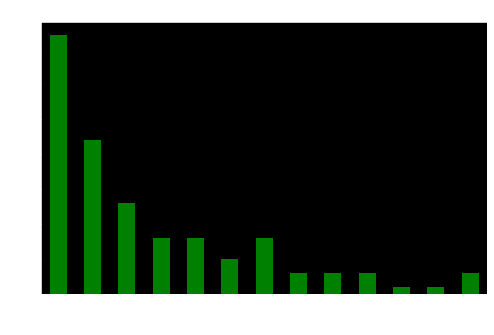

In [29]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

df_results['Total Venues'].plot(kind='bar', figsize=(8, 5), color = 'green')

plt.title('Dog-Friendly Districts') # add a title to the histogram
plt.xlabel('Number of dog-friendly venues') # add y-label
plt.ylabel('Number of districts') # add x-label

plt.show()

<p>Let's mark districts according to the amount of dog-friendly venues.</p>
<ul>
  <li>I will categorise the districts having 0 dog-friendly venues in their vicinity as not dog-friendly.</li>
  <li>Districts having at least 3 dog friendly venues will be mildly dog-friendly.</li>
  <li>Districts having more than 3 dog <span style="color: rgb(0, 0, 0); font-family: Times; font-size: medium; font-style: normal; font-variant-ligatures: normal; font-variant-caps: normal; font-weight: 400; letter-spacing: normal; orphans: 2; text-align: left; text-indent: 0px; text-transform: none; white-space: normal; widows: 2; word-spacing: 0px; -webkit-text-stroke-width: 0px; text-decoration-style: initial; text-decoration-color: initial; display: inline !important; float: none;">friendly venues will be very dog-friendly.</span></li>
</ul>
<p>I will mark them on the map with <span style="color: rgb(204, 204, 204);">Grey</span>, <span style="color: rgb(250, 197, 28);">Yellow</span> and <span style="color: rgb(97, 189, 109);">Green</span> markers accordingly.</p>

In [30]:
data['marker_color'] = 'grey'
for row in range(len(data)):
        if data.at[row,'Total'] == 0:
            data.at[row,'marker_color'] = 'grey'
        elif data.at[row,'Total'] <= 3:
            data.at[row,'marker_color'] = 'yellow'
        else:
            data.at[row,'marker_color'] = 'green'

In [31]:
stckhlm_map = folium.Map(location=[latitude, longitude], zoom_start=12) # generate map centred around Stockholm

# add the dog-friendly place as red circle markers
for index, row in data.iterrows():
    folium.CircleMarker([row['Lat'], row['Long']],
                    radius=10, color=row['marker_color'], fill = True,
                    fill_color=row['marker_color'], fill_opacity=0.6).add_to(stckhlm_map)

# display map
stckhlm_map

<p>According to the results it looks like Stockholm is quite dog-friendly with plenty of venues open for dogs in multiple districts.</p>
<p>Basing on this results, I would look further into the districts that have been categorized as dog-friendly and filter them further based on personal preferences: proximity to city center, urban/rural areas, etc.</p>